# Importing libraries

In [1]:
# Change directory to one level up to import the module
import os
os.chdir("..")

In [2]:
import tripsender.nhts as nhts
import pandas as pd
import matplotlib.pyplot as plt

# Load and clean data

In [3]:
# Read data
nhts_data = pd.read_csv('data/raw/NHTS/Data_RVU_2017_GBG_utanEXTRA.csv', sep=';')

# Preprocess data
df_persons = nhts.preprocess_data(nhts_data,unique_trips_only = True)

c:\Users\ssanjay\AppData\Local\Continuum\anaconda3\envs\tripsender\lib\site-packages\IPython\core\interactiveshell.py:3266: DtypeWarning: Columns (34,41,42,43) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# Change car count to 0 if 0 and 1 if 1 or more
df_persons['car_count'] = df_persons['car_count'].apply(lambda x: 0 if x == 0 else 1)


In [5]:
df_persons.head()

,weight_individual,id,sex,age_group,house_type,child_count,adult_count,household_type,car_count,start_time,purpose,mode,end_time,distance_km,activity_sequence
0,33.500,5.0,Män,35-44,Apartment,0.0,2.0,Couple,1,2023-11-14 09:00:00,Work,Walking,2023-11-14 09:15:00,1.6,0
1,33.500,5.0,Män,35-44,Apartment,0.0,2.0,Couple,1,2023-11-14 17:30:00,Home,Walking,2023-11-14 17:45:00,1.6,1
2,17.625,11.0,Kvinnor,75+,Apartment,0.0,1.0,Single,1,2023-11-14 12:10:00,Leisure,Bicycle/E-bike,2023-11-14 12:18:00,1.2,0
3,140.500,13.0,Män,16-24,Apartment,0.0,2.0,Couple,0,2023-11-14 07:30:00,Work,Bicycle/E-bike,2023-11-14 07:45:00,5.0,0
4,140.500,13.0,Män,16-24,Apartment,0.0,2.0,Couple,0,2023-11-14 17:10:00,Home,Bicycle/E-bike,2023-11-14 17:25:00,5.0,1


# Predict car ownership

<AxesSubplot:xlabel='sex'>

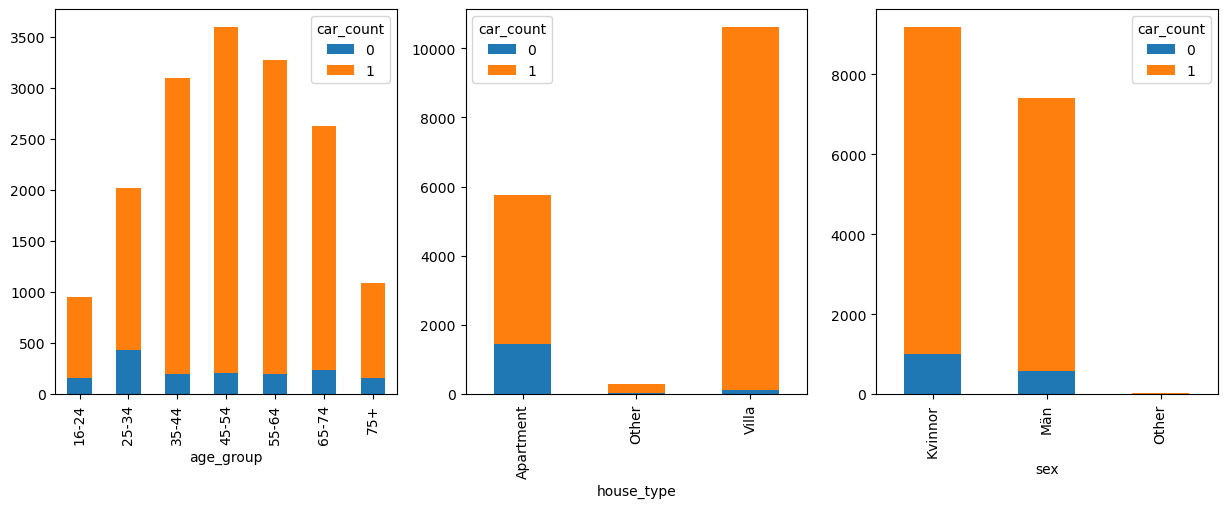

In [6]:
# Plot car ownership by age_group, house_type and sex
# Create subplots 3x1
fig, ax = plt.subplots(1,3,figsize=(15,5))

# plotting by age_group
df_persons.groupby(['age_group','car_count']).size().unstack().plot(kind='bar',stacked=True, ax=ax[0])
# plotting by age_group
df_persons.groupby(['house_type','car_count']).size().unstack().plot(kind='bar',stacked=True, ax=ax[1])
# plotting by age_group
df_persons.groupby(['sex','car_count']).size().unstack().plot(kind='bar',stacked=True, ax=ax[2])

In [7]:
df_persons.columns

Index(['weight_individual', 'id', 'sex', 'age_group', 'house_type',
       'child_count', 'adult_count', 'household_type', 'car_count',
       'start_time', 'purpose', 'mode', 'end_time', 'distance_km',
       'activity_sequence'],
      dtype='object')

# Setting up model for training

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
# import best_grid

# drop, id, start_time, purpose, mode, end_time distance_km and activity_sequence
df_persons_model = df_persons.drop(['id','start_time','purpose','mode','end_time','distance_km','activity_sequence','weight_individual'],axis=1)

# Convert categorical variables to one-hot encoded variables
ohe = OneHotEncoder(sparse=False)
categorical_variables = ['sex', 'age_group', 'house_type', 'household_type']


# One-hot encode categorical variables
df_persons_model_ohe = pd.DataFrame(ohe.fit_transform(df_persons_model[categorical_variables]))
df_persons_model_ohe.columns = ohe.get_feature_names()

# Merge with original dataframe and drop original categorical columns
df_persons_model = df_persons_model.drop(categorical_variables, axis=1).reset_index(drop=True)
df_persons_model = pd.concat([df_persons_model, df_persons_model_ohe], axis=1)

# Split dataset into training and test sets
X = df_persons_model.drop('car_count', axis=1)
X['x2_Not Available'] = 0
y = df_persons_model['car_count']

# Explain stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

print(y_train.value_counts())

1    11288
0     1189
Name: car_count, dtype: int64


overall accuracy score: 0.92
No car accuracy score: 0.36
Owning a car accuracy score: 0.98


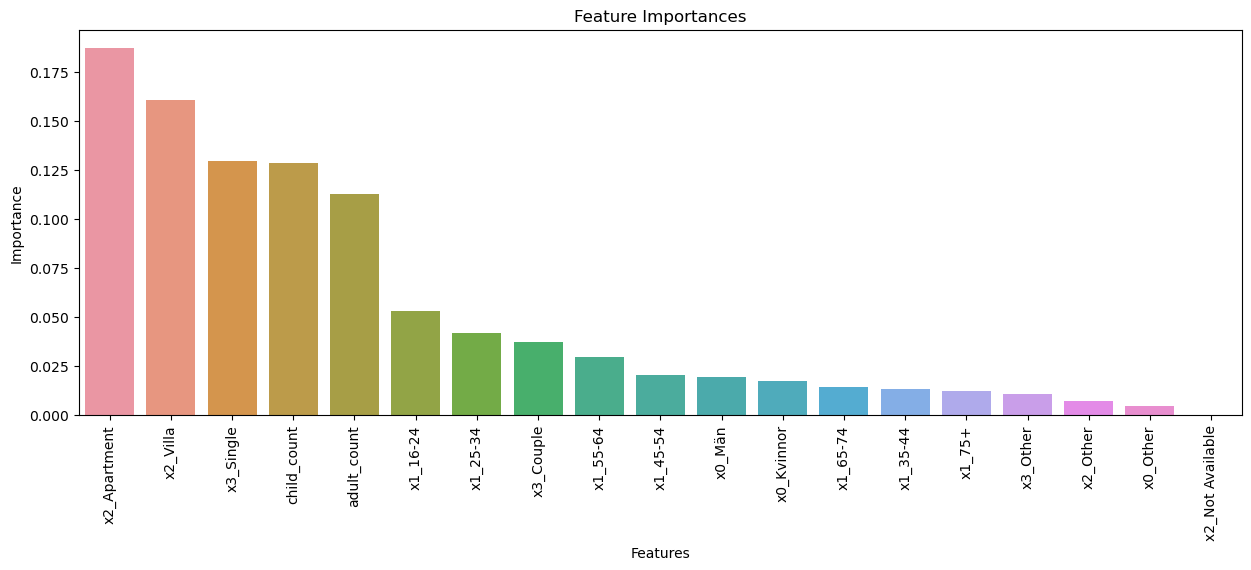

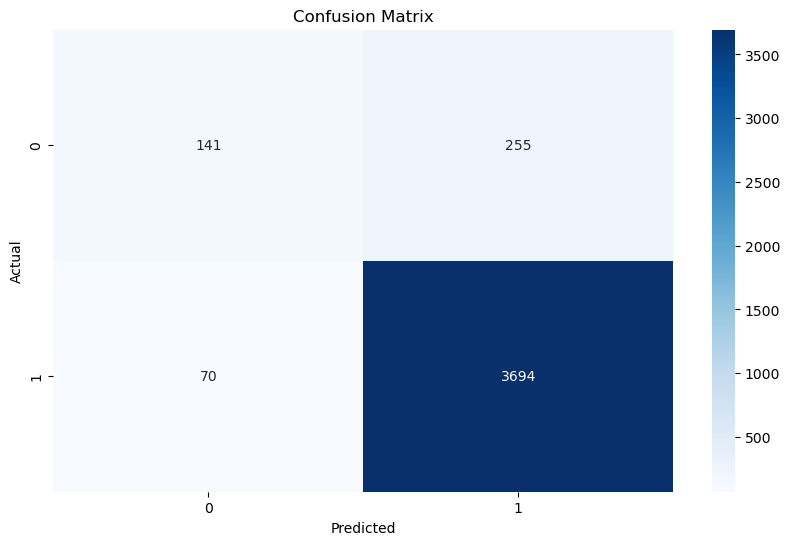

In [9]:
# Train a RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
# Predict on the test set
y_pred = rfc.predict(X_test)
# Evaluate the model
print(f"overall accuracy score: {accuracy_score(y_test, y_pred):.2f}")
# Print categorical accuracy
print(f"No car accuracy score: {accuracy_score(y_test[y_test == 0], y_pred[y_test == 0]):.2f}")
print(f"Owning a car accuracy score: {accuracy_score(y_test[y_test == 1], y_pred[y_test == 1]):.2f}")

cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)
# Visualize feature importances and confusion matrix
plt.figure(figsize=(15, 5))
sns.barplot(x='feature', y='feature_importance', data=pd.DataFrame({'feature': X.columns, 'feature_importance': rfc.feature_importances_}).sort_values('feature_importance', ascending=False))
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Hyper parameter training

In [10]:
from sklearn.metrics import classification_report, accuracy_score
"""
# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200], # Number of trees in random forest
    'max_features': ['auto', 'sqrt'], # Number of features to consider at every split
    'max_depth': [10, 20, 30, None], # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4], # Minimum number of samples required at each leaf node
    'bootstrap': [True, False] # Method of selecting samples for training each tree
}

# Initialize Random Forest Classifier
rf = RandomForestClassifier()

# Initialize GridSearch with 5-fold cross validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search model
grid_search.fit(X_train, y_train)
"""
# Get the best parameters from the grid search
best_params = {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
rfc_tuned = RandomForestClassifier(random_state=42, **best_params)
rfc_tuned.fit(X_train, y_train)
y_pred = rfc_tuned.predict(X_test)


# Evaluate the model
print(f"overall accuracy score: {accuracy_score(y_test, y_pred):.2f}")
# Print categorical accuracy
print(f"No car accuracy score: {accuracy_score(y_test[y_test == 0], y_pred[y_test == 0]):.2f}")
print(f"Owning a car accuracy score: {accuracy_score(y_test[y_test == 1], y_pred[y_test == 1]):.2f}")
#print("\nClassification Report:\n", classification_report(y_test, best_grid_predictions))

cm_hyperparameter = confusion_matrix(y_test, y_pred)
ac_hyperparameter = accuracy_score(y_test, y_pred)


overall accuracy score: 0.92
No car accuracy score: 0.35
Owning a car accuracy score: 0.98


# Weighting classes

In [11]:
# Calculate the unique class labels
unique_labels = np.unique(y_train)
# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', unique_labels, y_train)
# Convert class weights to a dictionary
class_weight_dict = {label: weight for label, weight in zip(unique_labels, class_weights)}
# Initialize and train the RandomForest with class weights
rfc_weighted = RandomForestClassifier(class_weight=class_weight_dict, random_state=42)
rfc_weighted.fit(X_train, y_train)
# Predictions and evaluation remain the same as before
y_pred = rfc_weighted.predict(X_test)
# Evaluate the model
print(f"overall accuracy score: {accuracy_score(y_test, y_pred):.2f}")
# Print categorical accuracy
print(f"No car accuracy score: {accuracy_score(y_test[y_test == 0], y_pred[y_test == 0]):.2f}")
print(f"Owning a car accuracy score: {accuracy_score(y_test[y_test == 1], y_pred[y_test == 1]):.2f}")
#print("\nClassification Report:\n", classification_report(y_test, best_grid_predictions))

cm_weight = confusion_matrix(y_test, y_pred)
ac_weight = accuracy_score(y_test, y_pred)

C:\Users\ssanjay\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=1646     1
1037     1
8344     0
4751     1
15205    1
        ..
7085     1
6514     1
15307    1
920      1
1776     0
Name: car_count, Length: 12477, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


overall accuracy score: 0.81
No car accuracy score: 0.86
Owning a car accuracy score: 0.80


# Weighting classes + hyperparameter tuning

In [12]:
# Calculate the unique class labels
unique_labels = np.unique(y_train)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', unique_labels, y_train)
# Convert class weights to a dictionary
class_weight_dict = {label: weight for label, weight in zip(unique_labels, class_weights)}
# Initialize and train the RandomForest with class weights
# {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
rfc_weighted_tuned = RandomForestClassifier(class_weight=class_weight_dict, random_state=42, bootstrap=True, max_depth=30, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=10)
rfc_weighted_tuned.fit(X_train, y_train)
# Predictions and evaluation remain the same as before
y_pred = rfc_weighted.predict(X_test)
# Evaluate the model
print(f"overall accuracy score: {accuracy_score(y_test, y_pred):.2f}")
# Print categorical accuracy
print(f"No car accuracy score: {accuracy_score(y_test[y_test == 0], y_pred[y_test == 0]):.2f}")
print(f"Owning a car accuracy score: {accuracy_score(y_test[y_test == 1], y_pred[y_test == 1]):.2f}")
#print("\nClassification Report:\n", classification_report(y_test, best_grid_predictions))
cm_weight_hyperparameter = confusion_matrix(y_test, y_pred)
ac_weight_hyperparameter = accuracy_score(y_test, y_pred)

overall accuracy score: 0.81


C:\Users\ssanjay\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=1646     1
1037     1
8344     0
4751     1
15205    1
        ..
7085     1
6514     1
15307    1
920      1
1776     0
Name: car_count, Length: 12477, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


No car accuracy score: 0.86
Owning a car accuracy score: 0.80


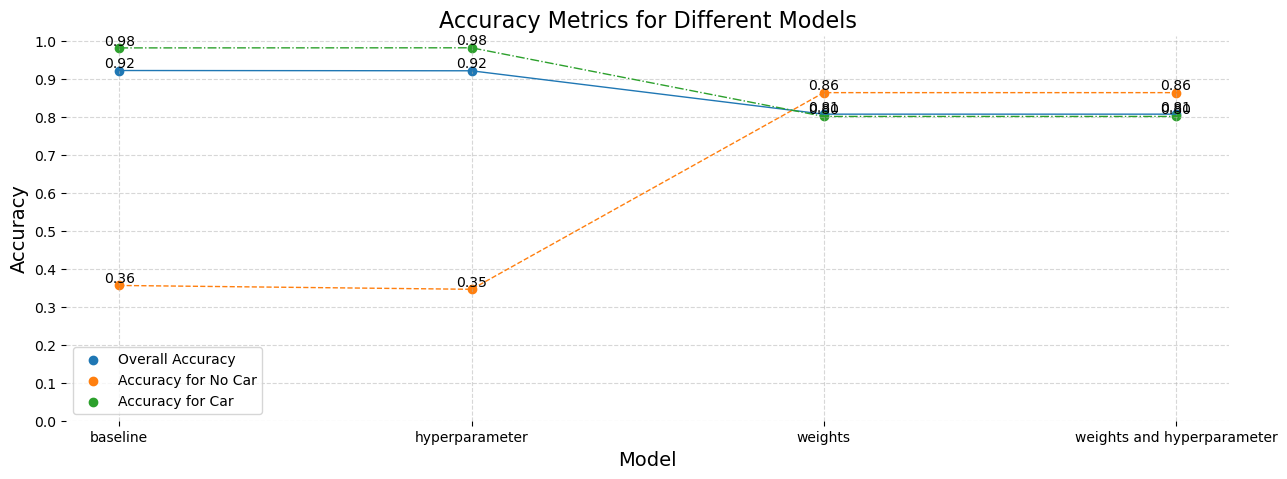

In [31]:
list_of_cm_array = [cm, cm_hyperparameter, cm_weight, cm_weight_hyperparameter]
list_of_accuracies = [ac, ac_hyperparameter, ac_weight, ac_weight_hyperparameter]
list_of_model_names = ['baseline', 'hyperparameter', 'weights', 'weights and hyperparameter']

# Define a function to calculate class accuracy
def class_accuracy(cm):
    # Diagonal elements are true positives for each class
    true_positives = [cm[i][i] for i in range(2)]
    
    # Sum of each row gives the total number of instances for each class
    total_instances = [sum(row) for row in cm]
    
    return [tp/tot if tot != 0 else 0 for tp, tot in zip(true_positives, total_instances)]

# Calculate class-specific accuracies for each confusion matrix
class_accuracies = [class_accuracy(cm) for cm in list_of_cm_array]

# Separate out accuracies for each class
class_1_accuracies = [acc[0] for acc in class_accuracies]
class_2_accuracies = [acc[1] for acc in class_accuracies]

# Create a DataFrame
df_cm = pd.DataFrame({
    'model': list_of_model_names,
    'overall_accuracy': list_of_accuracies,
    'Accuracy for No Car': class_1_accuracies,
    'Accuracy for Car': class_2_accuracies
})
df_cm.set_index('model', inplace=True)

# Plot the accuracies
# Plot the accuracies as line plots
plt.figure(figsize=(15, 5))

# Add a marker with a label at data point
plt.scatter(df_cm.index, df_cm['overall_accuracy'], marker='o', label='Overall Accuracy')
plt.scatter(df_cm.index, df_cm['Accuracy for No Car'], marker='o', label='Accuracy for No Car')
plt.scatter(df_cm.index, df_cm['Accuracy for Car'], marker='o', label='Accuracy for Car')
plt.legend()

plt.plot(df_cm.index, df_cm['overall_accuracy'], label='Overall Accuracy', linewidth=1)
plt.plot(df_cm.index, df_cm['Accuracy for No Car'], label='Accuracy for No Car', linewidth=1, linestyle='--')
plt.plot(df_cm.index, df_cm['Accuracy for Car'], label='Accuracy for Car', linewidth=1, linestyle='-.')
plt.title('Accuracy Metrics for Different Models', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=0)




# Add a data label for each point
for x, y in zip(df_cm.index, df_cm['overall_accuracy']):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')
for x, y in zip(df_cm.index, df_cm['Accuracy for No Car']):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')
for x, y in zip(df_cm.index, df_cm['Accuracy for Car']):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')
plt.grid(True, linestyle='--', alpha=0.5)

# Remove all spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)


# Make y ticks from 0 to 1 with 0.1 spacing
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()


# Exploring the model predictions

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


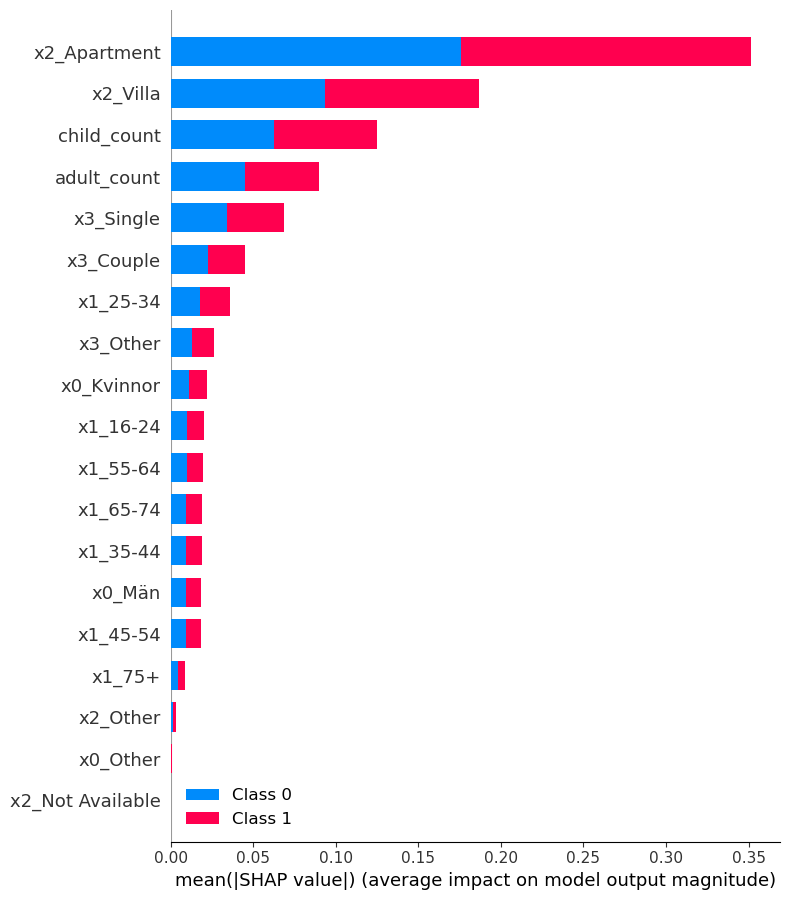

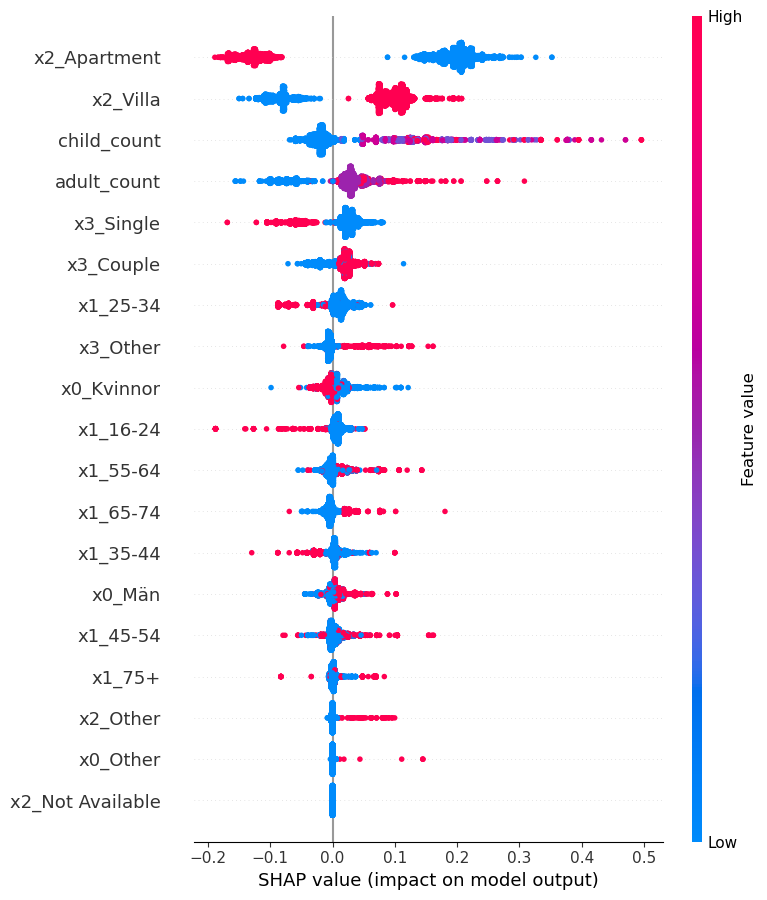

In [14]:
import shap

# Initialize the Tree Explainer
explainer = shap.TreeExplainer(rfc_weighted_tuned)

# Calculate SHAP values for a sample
shap_values = explainer.shap_values(X_test, check_additivity=False)

shap.summary_plot(shap_values, X_test)
# Plot the SHAP values for a specific class (e.g., class 1)
shap.summary_plot(shap_values[1], X_test)


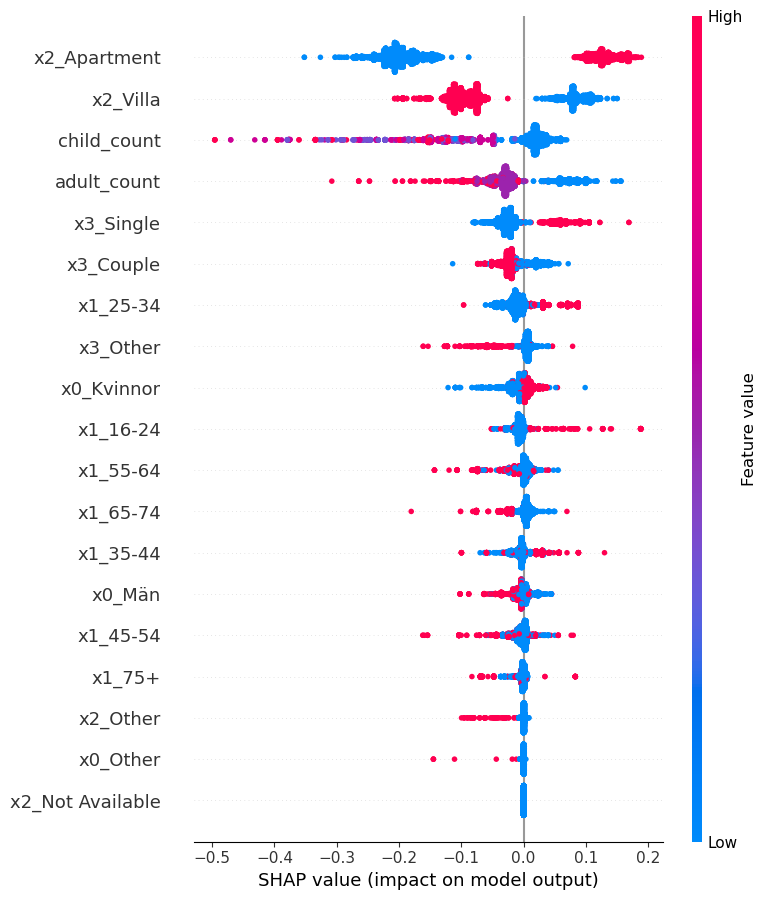

In [15]:
# Plot the SHAP values for a specific class (e.g., class 1)
shap.summary_plot(shap_values[0], X_test)

# Save the model

In [16]:
import joblib
# Save the model to disk
joblib.dump(rfc_weighted_tuned, 'models/NHTS_CAR_OWNERSHIP_CLASSIFIER.joblib')

['models/NHTS_CAR_OWNERSHIP_CLASSIFIER.joblib']